Welcome to the notebook for our paper Robust Testing for Deep Learning using Human Label Noise! 🎉
Our paper has three key parts:

* A deep dive into label memorization of human noisy labels on the CIFAR-10 dataset.
* A cluster-based noising algorithm inspired by our findings on label memorization.
* The introduction of Soft Neighbor Label Sampling as a new approach.

This notebook focuses on the first part: studying label memorization of human noisy labels on CIFAR-10. Here, we’ll reproduce Figures 1–4 from the paper to showcase our results.

**Overview of what we’ll do in this notebook:**

1. Plot results of label memorization from heldout estimation (Figure 1).
2. Define incorrect learned human noisy labels using inclusion/exclusion probabilities (Figure 2).
3. Plot incorrect learned human noisy labels within a t-SNE plot of CIFAR-10 images’ CLIP embeddings (Figure 3).
4. Show the Top 10 closest images with incorrect learned human noisy labels within the classes (Figure 4).

Let’s get started! 🚀

## 0. Import required dependencies and load data files

In [1]:
import os
import random

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import numpy as np
import pandas as pd
from matplotlib import patches
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from transformers import CLIPModel

CIFAR-10N provides human-annotated noisy labels for the CIFAR-10 training dataset, which will serve as the basis for our study.

In [2]:
!wget -O CIFAR-10_human.pt https://github.com/UCSC-REAL/cifar-10-100n/raw/refs/heads/main/data/CIFAR-10_human.pt # CIFAR-10N Human Noisy Labels

--2025-01-15 10:40:01--  https://github.com/UCSC-REAL/cifar-10-100n/raw/refs/heads/main/data/CIFAR-10_human.pt
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/UCSC-REAL/cifar-10-100n/refs/heads/main/data/CIFAR-10_human.pt [following]
--2025-01-15 10:40:01--  https://raw.githubusercontent.com/UCSC-REAL/cifar-10-100n/refs/heads/main/data/CIFAR-10_human.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2401007 (2.3M) [application/octet-stream]
Saving to: ‘CIFAR-10_human.pt’

CIFAR-10_human.pt   100%[===================>]   2.29M  --.-KB/s    in 0.1s    

2025-01-15 10:40:01 (19.2 MB/s) - ‘CIFAR-10

In [3]:
cifar10n_label = torch.load('CIFAR-10_human.pt') 
clean_label = cifar10n_label['clean_label'] 
hu_rand1 = cifar10n_label['random_label1']

The CIFAR-10N authors also generated synthetic label noise for comparison using class-dependent noise synthesized with the same transition matrix as the human labels. We reproduced their synthetic label noise using their [repository](https://github.com/UCSC-REAL/cifar-10-100n/blob/main/data/datasets.py) and the following arguments:

```python
args = {
    'noise_type': 'random_label1',  # Options: clean_label, random_label1, random_label2, etc.
    'dataset': 'cifar10',   # Options: cifar10 or cifar100
    'noise_path': 'CIFAR-10_human.pt',     # Human noisy labels used to derive the transition matrix
    'is_human': False       # Indicates synthetic (non-human) noise
}

train_dataset, _, _, _ = input_dataset(args['dataset'], noise_type, args['noise_path'], args['is_human'])
```

In [4]:
syn_rand1_df = pd.read_csv('cifar_rand1_syn_labels.csv')
syn_rand1 = syn_rand1_df['noisy_label']

To quantify label memorization in our study, we use the definition introduced in [Feldman et al., 2020](https://arxiv.org/abs/2008.03703):  
For a learning algorithm $ \mathcal{A} $ trained on a dataset $ S = ((x_1, y_1), \ldots, (x_n, y_n)) $, the memorization of an example $ (x_i, y_i) \in S $ is defined as:

$$
\text{mem}(\mathcal{A}, S, i) := \Pr_{h \sim \mathcal{A}(S)}[h(x_i) = y_i] - \Pr_{h \sim \mathcal{A}(S^{\backslash i})}[h(x_i) = y_i],
$$

where $ S^{\backslash i} $ denotes the dataset $ S $ with $ (x_i, y_i) $ removed, and the probability is computed over the randomness in the learned model $ h(\cdot) $ due to the inherent randomness of $ \mathcal{A} $, such as through random initialization.

We calculated label memorization using heldout estimation as described in *What Neural Networks Memorize and Why: Discovering the Long Tail via Influence Estimation* (Feldman et al.) [[paper]](https://arxiv.org/abs/2008.03703) [[repo]](https://github.com/google-research/heldout-influence-estimation/tree/master). To further reduce computational cost, we limited the estimation of memorization values to a subset of labels, referred to as the heldout set. This subset included both the incorrect noisy labels and an equal number of correct labels for comparison. Specifically, we trained 1,500 ResNet34 [25] models, each excluding a randomly sampled 30% of the heldout set from the training data. This process was conducted for both human noisy labels and synthetic noisy label sets. 

NOTE: Although this method also generates influence scores for each training and test image pair, we did not use these scores in our analysis.

In [5]:
hu_infl_mem = np.load('cifar-rand1-human-infl-mem.npz')
syn_infl_mem = np.load('cifar-rand1-syn-infl-mem.npz')

In [6]:
def process_influence_memory(infl_mem, noisy_label):
    """Process the loaded influence memory and calculate the heldout indices."""
    # Get heldout noisy indices based on label mismatches
    heldout_noisy_idx = np.where(noisy_label != clean_label)[0]
    heldout_idx = np.where(~infl_mem['trainset_mask'].all(axis=0))[0]
    heldout_clean_idx = list(set(heldout_idx) - set(heldout_noisy_idx))

    # Make sure noisy and clean heldout indices are the same length
    assert len(heldout_noisy_idx) == len(heldout_clean_idx), "Noisy and clean held-out indices must be equal in length."

    all_idx = np.arange(len(noisy_label))
    not_heldout_idx = np.setdiff1d(all_idx, heldout_idx)

    return {k: v for k, v in locals().items() if k != 'infl_mem'}

In [7]:
hu_infl_mem_idx = process_influence_memory(hu_infl_mem, hu_rand1)
syn_infl_mem_idx = process_influence_memory(syn_infl_mem, syn_rand1)

## 1. Plot results of label memorization from heldout estimation (Figure 1).

**Intuition:** Human noisy labels are more difficult due to NNs learning their erroneous patterns without needing memorization.

In [8]:
hu_infl_mem_noisy_idx = hu_infl_mem_idx['heldout_noisy_idx'] 
syn_infl_mem_noisy_idx = syn_infl_mem_idx['heldout_noisy_idx']

hu_mem_noisy = hu_infl_mem['memorization'][hu_infl_mem_noisy_idx]
syn_mem_noisy = syn_infl_mem['memorization'][syn_infl_mem_noisy_idx]

hu_infl_mem_clean_idx = hu_infl_mem_idx['heldout_clean_idx'] 
syn_infl_mem_clean_idx = syn_infl_mem_idx['heldout_clean_idx']

hu_mem_clean = hu_infl_mem['memorization'][hu_infl_mem_clean_idx]
syn_mem_clean = syn_infl_mem['memorization'][syn_infl_mem_clean_idx]

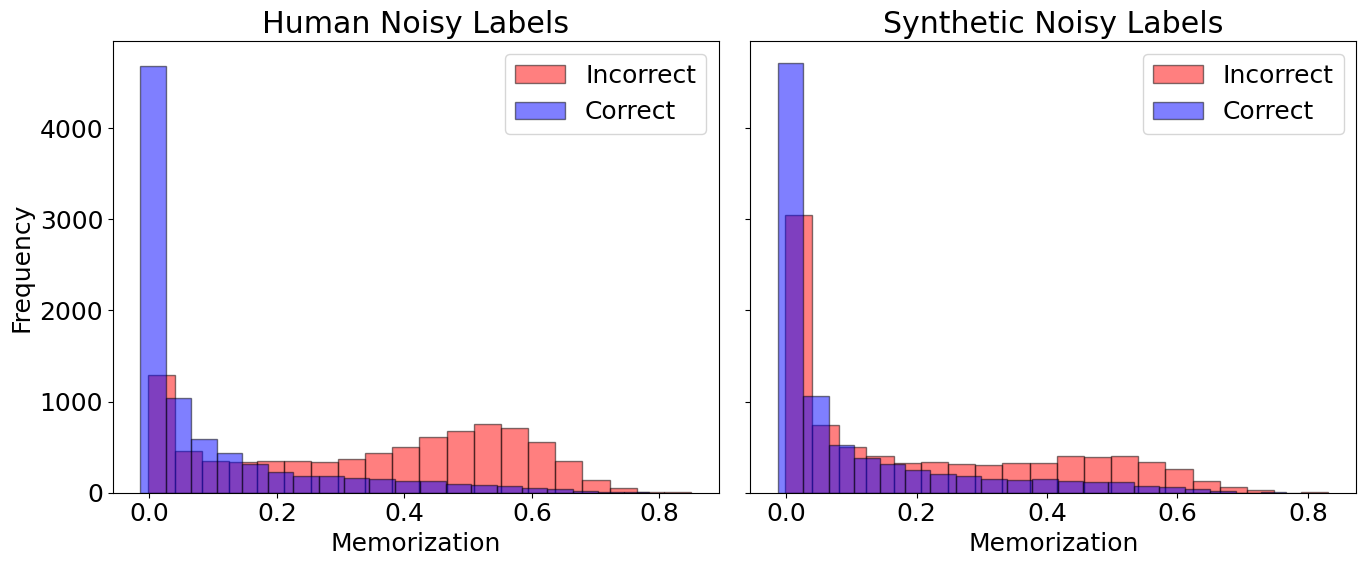

In [9]:
# Function to plot histograms with specified colors
def plot_histograms_side_by_side(data1, data2, data3, data4, label1, label2, title1, title2):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    
    # Plot for the first dataset (Human Noisy Labels)
    axes[0].hist(data1, bins=20, alpha=0.5, label=label1, edgecolor='black', color='red')
    axes[0].hist(data2, bins=20, alpha=0.5, label=label2, edgecolor='black', color='blue')
    axes[0].set_xlabel('Memorization')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(title1)
    axes[0].legend(loc='upper right')

    # Plot for the second dataset (Synthetic Class-dependent Noisy Labels)
    axes[1].hist(data3, bins=20, alpha=0.5, label=label1, edgecolor='black', color='red')
    axes[1].hist(data4, bins=20, alpha=0.5, label=label2, edgecolor='black', color='blue')
    axes[1].set_xlabel('Memorization')
    axes[1].set_title(title2)
    axes[1].legend(loc='upper right')
    
    plt.tight_layout()
    plt.savefig('memorization-histogram.pdf', dpi=300)
    plt.show()

# Plot side-by-side histograms for human noisy labels and synthetic noisy labels
plot_histograms_side_by_side(hu_mem_noisy, hu_mem_clean, syn_mem_noisy, syn_mem_clean, 'Incorrect', 'Correct', 'Human Noisy Labels', 'Synthetic Noisy Labels')

**Observation:** Incorrect labels in the synthetic noisy label set exhibit a higher proportion of low memorization scores compared to human noisy labels.

This observation challenges our earlier intuition. To better understand this, we analyze the two components of the memorization score separately: the inclusion probability, $ \Pr_{h \sim \mathcal{A}(S)}[h(x_i) = y_i] $, and the exclusion probability, $ \Pr_{h \sim \mathcal{A}(S^{\backslash i})}[h(x_i) = y_i] $.

## 2. Define incorrect learned human noisy labels using inclusion/exclusion probabilities (Figure 2).

In [10]:
hu_infl_mem_inclusion_prob = hu_infl_mem['memorization_inclusion_prob']
hu_infl_mem_exclusion_prob = hu_infl_mem['memorization_exclusion_prob']

hu_infl_mem_inclusion_prob_noisy = hu_infl_mem_inclusion_prob[hu_infl_mem_noisy_idx]
hu_infl_mem_exclusion_prob_noisy = hu_infl_mem_exclusion_prob[hu_infl_mem_noisy_idx]

hu_infl_mem_inclusion_prob_clean = hu_infl_mem_inclusion_prob[hu_infl_mem_clean_idx]
hu_infl_mem_exclusion_prob_clean = hu_infl_mem_exclusion_prob[hu_infl_mem_clean_idx]

In [11]:
syn_infl_mem_inclusion_prob = syn_infl_mem['memorization_inclusion_prob']
syn_infl_mem_exclusion_prob = syn_infl_mem['memorization_exclusion_prob']

syn_infl_mem_inclusion_prob_noisy = syn_infl_mem_inclusion_prob[syn_infl_mem_noisy_idx]
syn_infl_mem_exclusion_prob_noisy = syn_infl_mem_exclusion_prob[syn_infl_mem_noisy_idx]

syn_infl_mem_inclusion_prob_clean = syn_infl_mem_inclusion_prob[syn_infl_mem_clean_idx]
syn_infl_mem_exclusion_prob_clean = syn_infl_mem_exclusion_prob[syn_infl_mem_clean_idx]

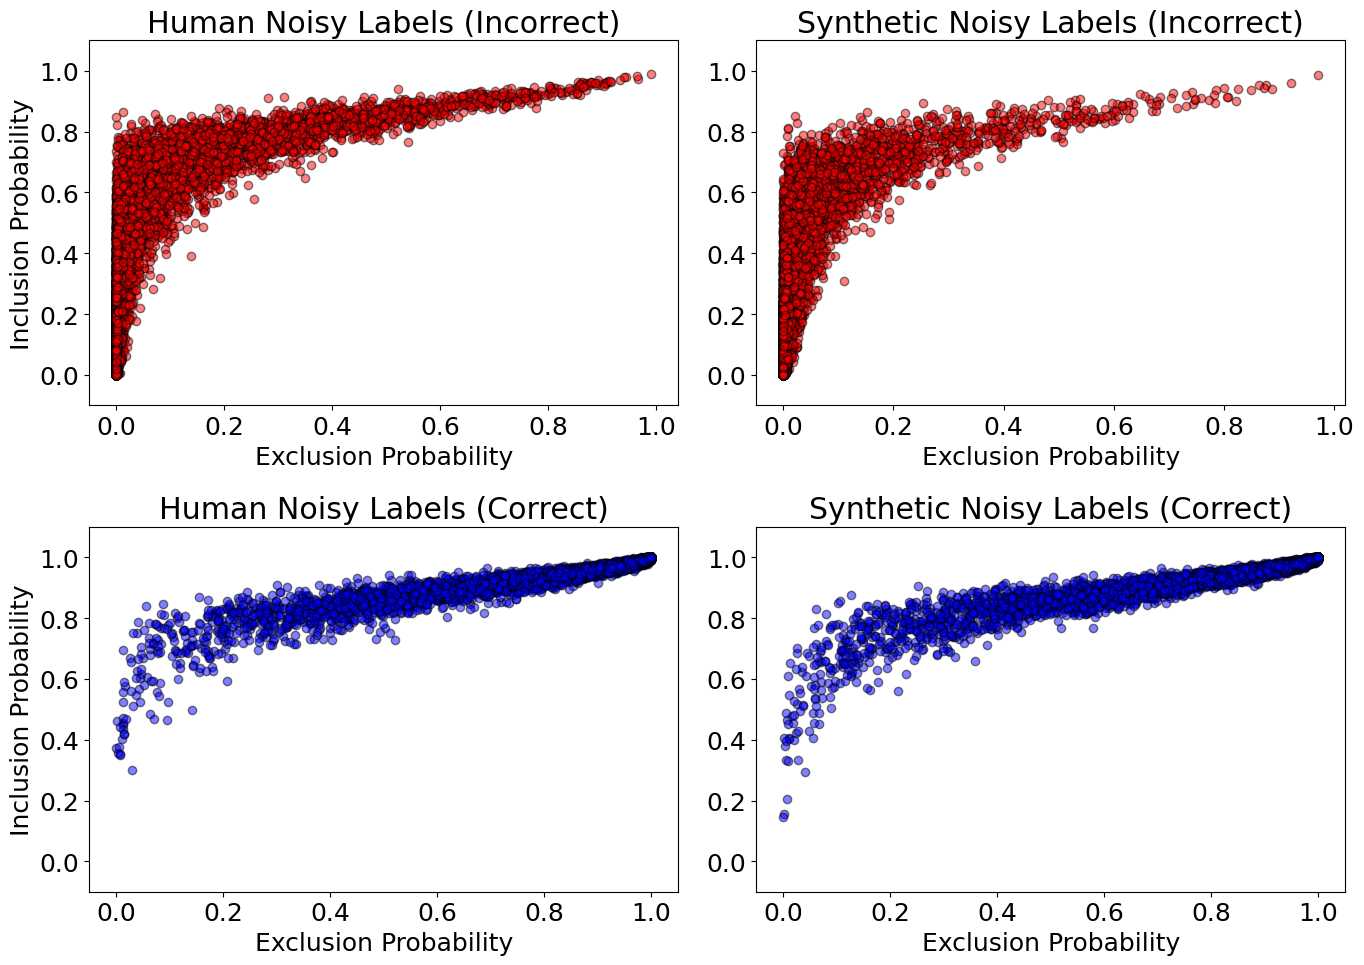

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

y_min, y_max = -0.1, 1.1
y_ticks = np.arange(0, 1.2, 0.2)

# Scatter plots for noisy labels (top row - pure red for incorrect)
axs[0, 0].scatter(hu_infl_mem_exclusion_prob_noisy, hu_infl_mem_inclusion_prob_noisy, color='#FF0000', alpha=0.5, label='Human', edgecolor='black')
axs[0, 0].set_title('Human Noisy Labels (Incorrect)')
axs[0, 0].set_xlabel('Exclusion Probability')
axs[0, 0].set_ylabel('Inclusion Probability')
axs[0, 0].set_ylim(y_min, y_max)
axs[0, 0].set_yticks(y_ticks)

axs[0, 1].scatter(syn_infl_mem_exclusion_prob_noisy, syn_infl_mem_inclusion_prob_noisy, color='#FF0000', alpha=0.5, label='Synthetic', edgecolor='black')
axs[0, 1].set_title('Synthetic Noisy Labels (Incorrect)')
axs[0, 1].set_xlabel('Exclusion Probability')
axs[0, 1].set_ylim(y_min, y_max)
axs[0, 1].set_yticks(y_ticks)

# Scatter plots for clean labels (bottom row - pure blue for correct)
axs[1, 0].scatter(hu_infl_mem_exclusion_prob_clean, hu_infl_mem_inclusion_prob_clean, color='#0000FF', alpha=0.5, label='Human', edgecolor='black')
axs[1, 0].set_title('Human Noisy Labels (Correct)')
axs[1, 0].set_xlabel('Exclusion Probability')
axs[1, 0].set_ylabel('Inclusion Probability')
axs[1, 0].set_ylim(y_min, y_max)
axs[1, 0].set_yticks(y_ticks)

axs[1, 1].scatter(syn_infl_mem_exclusion_prob_clean, syn_infl_mem_inclusion_prob_clean, color='#0000FF', alpha=0.5, label='Synthetic', edgecolor='black')
axs[1, 1].set_title('Synthetic Noisy Labels (Correct)')
axs[1, 1].set_xlabel('Exclusion Probability')
axs[1, 1].set_ylim(y_min, y_max)
axs[1, 1].set_yticks(y_ticks)

for ax in axs.flat:
    ax.grid(False)

plt.tight_layout()
plt.savefig('incl-excl-scatter.pdf', dpi=300)
plt.show()

💡 The distribution is notably denser for human noisy labels when both probabilities exceed 0.6. We refer to these as *incorrect learned human noisy labels*, representing labels that pose a challenge for LNL methods. These labels are learned without memorization, despite being incorrect. Let's display a sample of these images below.

Files already downloaded and verified


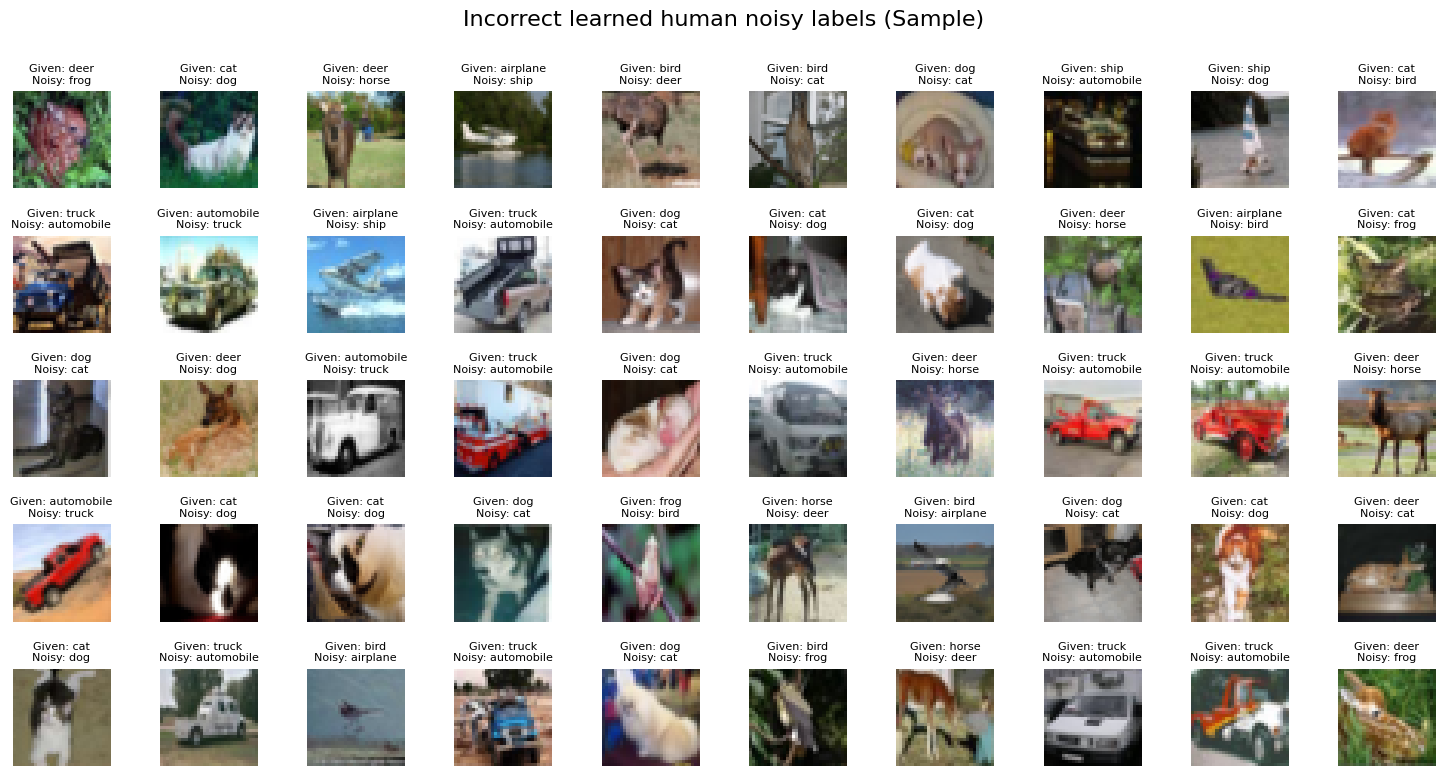

In [20]:
# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
cifar10_trainset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
cifar10_classes = cifar10_trainset.classes

# Filter to find indices that are within 'hu_infl_mem_noisy_idx' and satisfy the condition inclusion > 0.6, exclusion > 0.6
selected_idx = [idx for idx in hu_infl_mem_noisy_idx if (hu_infl_mem_inclusion_prob[idx] > 0.6 and hu_infl_mem_exclusion_prob[idx] > 0.6)]
sampled_idx = random.sample(selected_idx, 50)

# Create a 5x10 grid for displaying the selected sample images from training data
fig, axes = plt.subplots(5, 10, figsize=(15, 8))
fig.suptitle('Incorrect learned human noisy labels (Sample)', fontsize=16)

# Display the images
for i, ax in enumerate(axes.flat):
    train_idx = sampled_idx[i]
    train_image, given_label = cifar10_trainset[train_idx]
    noisy_label = hu_rand1[train_idx]
    ax.imshow(np.transpose(train_image.numpy(), (1, 2, 0))) 
    ax.axis('off')  # Hide axes

    # Set the title to display both the given and noisy labels
    ax.set_title(f"Given: {cifar10_classes[given_label]}\nNoisy: {cifar10_classes[noisy_label]}", fontsize=8)

plt.tight_layout()
plt.show()

In [14]:
# Step 1: Identify Points with High Inclusion and Exclusion Probabilities
# Create boolean masks for inclusion and exclusion probabilities > 0.6
high_inclusion_mask = hu_infl_mem_inclusion_prob > 0.6
high_exclusion_mask = hu_infl_mem_exclusion_prob > 0.6

# Combine masks to get points satisfying both conditions
high_both_mask = np.logical_and(high_inclusion_mask, high_exclusion_mask)

# Get indices of these points within the noisy data subset
high_both_indices = np.where(high_both_mask)[0]

# Step 2: Identify combine with noisy idx to get *noisy* points with High Inclusion and Exclusion Probabilities
high_both_indices_noisy = np.intersect1d(high_both_indices, hu_infl_mem_noisy_idx)

print(len(high_both_indices_noisy))

222


## 3. Plot *incorrect learned human noisy labels* within a t-SNE plot of CIFAR-10 images’ CLIP embeddings (Figure 3).

In [15]:
# Define the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Step 1: Load and Transform CIFAR-10 Training Set
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 as expected by CLIP
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],  # CLIP's mean normalization
                         std=[0.26862954, 0.26130258, 0.27577711])   # CLIP's std normalization
])
train_dataset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                             download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=2)

# Step 2: Load the CLIP Model
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
model.to(device)
model.eval()

# Step 3: Compute CLIP Embeddings
clip_embeddings = []
labels = []

with torch.no_grad():
    for images, targets in train_loader:
        images = images.to(device)
        outputs = model.get_image_features(pixel_values=images)
        embeddings = outputs / outputs.norm(p=2, dim=-1, keepdim=True)
        embeddings = embeddings.cpu().numpy()
        clip_embeddings.append(embeddings)
        labels.extend(targets.numpy())

clip_embeddings = np.concatenate(clip_embeddings, axis=0)
labels = np.array(labels)

print("CLIP Embeddings shape:", clip_embeddings.shape)
print("Labels shape:", labels.shape)

# Dimensionality Reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(clip_embeddings)

Files already downloaded and verified
CLIP Embeddings shape: (50000, 512)
Labels shape: (50000,)


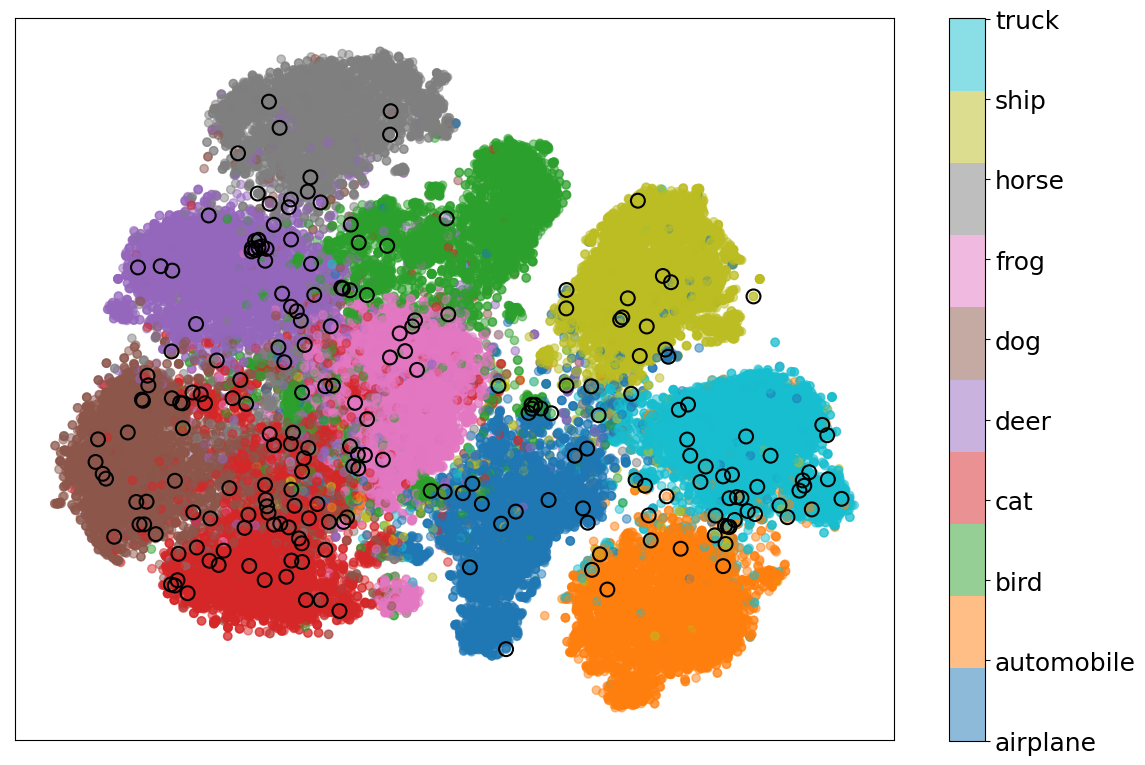

In [16]:
plt.figure(figsize=(12, 8))

# Plot all points colored by their CIFAR-10 labels
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                      c=labels, cmap='tab10', alpha=0.5)

# Overlay points with high inclusion and exclusion probabilities
plt.scatter(embeddings_2d[high_both_indices_noisy, 0], embeddings_2d[high_both_indices_noisy, 1],
            facecolors='none', edgecolors='k', linewidths=1.5, s=100,
            label='High Inclusion & Exclusion Prob')

# Remove x and y ticks
plt.xticks([])
plt.yticks([])

# Update colorbar to reflect CIFAR-10 classes
cbar = plt.colorbar(scatter, ticks=range(10))
cbar.set_ticks(range(10))
cbar.set_ticklabels(['airplane', 'automobile', 'bird', 'cat', 'deer',
                     'dog', 'frog', 'horse', 'ship', 'truck'])

plt.tight_layout()
plt.savefig('cifar10n-clip-embeddings.pdf', dpi=300)
plt.show()

Annotated points represent incorrect learned human noisy labels. There appear to be subclusters of these labels within their correct class clusters. 👀

## 4. Show the Top 10 closest images with *incorrect learned human noisy labels* within the classes (Figure 4).

In [30]:
# Step 1: Define the class of interest (e.g., the "purple cluster" corresponds to 'deer')
class_id = 4  # e.g., 4 for 'deer'
class_indices = np.where(labels == class_id)[0]

Files already downloaded and verified


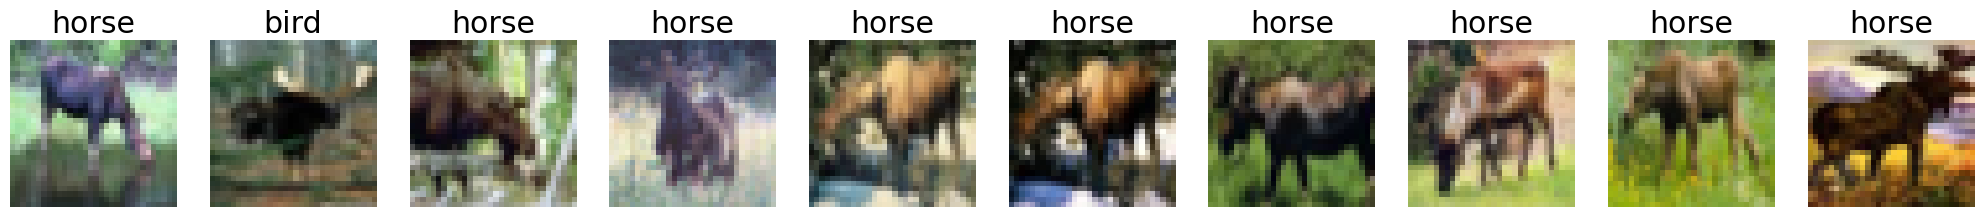

In [31]:
# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
cifar10_trainset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)

# Step 2: Filter the high inclusion/exclusion points within the selected class
high_incl_excl_in_class = np.intersect1d(high_both_indices_noisy, class_indices)

# Ensure we have some points to work with
if len(high_incl_excl_in_class) == 0:
    print("No high inclusion/exclusion points found for the given class.")
else:
    # Step 3: Extract the 2D t-SNE coordinates for the points in the selected class
    class_coords = embeddings_2d[high_incl_excl_in_class]

    # Step 4: Calculate pairwise distances in 2D t-SNE space for the filtered points
    pairwise_distances = squareform(pdist(class_coords, 'euclidean'))

    # Step 5: Select a tight subcluster by proximity (e.g., top N closest points or using a distance threshold)
    N = min(10, len(high_incl_excl_in_class))  # Ensure N doesn't exceed available points
    sorted_indices = np.argsort(pairwise_distances.sum(axis=1))[:N]  # Sum distances and select top N closest points
    tight_subcluster_indices = high_incl_excl_in_class[sorted_indices]

    # Display the images corresponding to the tight subcluster with both given and noisy labels
    num_images = len(tight_subcluster_indices)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    
    for i, idx in enumerate(tight_subcluster_indices):
        train_image, train_label = cifar10_trainset[idx]  # Given label
        noisy_label = hu_rand1[idx]  # Noisy label
    
        axes[i].imshow(np.transpose(train_image.numpy(), (1, 2, 0)))
        axes[i].axis('off')  # Hide axes
        axes[i].set_title(f'{cifar10_trainset.classes[noisy_label]}') 
    
    # Adjust spacing to reduce gaps
    plt.subplots_adjust(wspace=0.05)
    plt.tight_layout(pad=0.1)
    
    # Add a rectangular box around the row of images, edgecolor needs to adjusted to match t-SNE color mapping
    # left, bottom, width, height = 0.0, -0.1, 1, 1.2  # Adjust these values as needed
    # rect = patches.Rectangle((left, bottom), width, height, linewidth=4, edgecolor='#b9bb1e', facecolor='none', transform=fig.transFigure)
    # fig.patches.append(rect)
    
    plt.savefig(f'cifar10n-{cifar10_trainset.classes[class_id]}-cluster.pdf', dpi=300, bbox_inches='tight')
    plt.show()